In [1]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from itertools import product

In [2]:
def StochasticBlockModel(n, k, p, q, plot=False):
    # n: number of vertices
    # k: number of clusters
    """It outputs a graph on n*k vertices with k clusters of size n. Between two different clusters we draw an edge 
    with probability q. Inside a cluster we draw an edge with probability p."""
    probs = np.ones((k, k))*q
    np.fill_diagonal(probs, p)
    sizes = [n]*k
    G = nx.stochastic_block_model(sizes=sizes, p=probs, seed=0)
    if plot:
        nx.draw(G)
    return G

In [5]:
def LaplacianSpectralClustering(G, r, k):
    # G: graph
    # r: r-smallest eigenvalues excluding 0
    # k: k cluster for k-means algorithm
    """We take the r smallest eigenvalues of the Laplacian matrix not including the smallest 0 eigenvector. 
    Then we use the corresponding eigenvectors to represent the vertices of G as vectors in R^r. 
    Then we use k-means algorithm with k-means++ initialization to cluster the graph into k clusters."""
    
    # Laplacian-matrix representation of G
    # the .A attribute ensures that the output is a dense matrix with np.array datatype
    L = nx.laplacian_matrix(G).A
    
    # Calculate the eigenvalues and corr. eigenvectors of L
    # w: eigenvalues of L in an ascending order! very convenient
    # v: corresponding eigenvectors
    w, v = eigh(L)
    
    # the KMeans().fit(X) method expects an array-like X of shape (n_samples, n_features)
    # as we project the eigenvectors to R^r we need to transpose w to acquire the projection of the vertices
    
    #kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10).fit(v[1:r+1].T) helyett írj a kódodba
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10).fit(v[:,1:r+1]) #sort és működni fog.
    return kmeans

In [6]:
def Measurements(n, k, iteration=10, plot=False):
    # n: number of vertices
    # k: k cluster for k-means algorithm
    """It outputs a 5x5 matrix filled with adjusted Rand scores as follows. For p in [0.6,0.7,0.8,0.9,1] and 
    q in [0.1,0.2,0.3,0.4,0.5] it creates a Stochastic Block Graph with parameters n,k,p,q, then apply the 
    Laplacian Spectral Clustering with r=k-1 and finally compare the true labels with the obtained ones via adjusted Rand 
    score. We do it iteration times for fixed p,q and take the average of these values."""
    
    # Initialize parameters
    P = [0.6, 0.7, 0.8, 0.9, 1]
    Q = [0.1, 0.2, 0.3, 0.4, 0.5]
    results = []
    for p in P:
        result = []
        for q in Q:
            # Stochastic Block Graph
            G = StochasticBlockModel(n=n, k=k, p=p, q=q, plot=plot)
            measurement = []
            for j in range(iteration):
                # Laplacian Spectral Clustering
                kmeans = LaplacianSpectralClustering(G=G, r=k-1, k=k)
                # Comparison
                labels_true = np.hstack([np.repeat(i, n) for i in range(k)])
                labels_pred = kmeans.labels_
                score = adjusted_rand_score(labels_true, labels_pred)
                measurement.append(score)
            result.append(np.mean(measurement))
        results.append(result)
    return np.array(results)

# Example

First I will show the workflow using a toy-example.

## Create a stochastic block model

I found the `networkx` implementation pretty convenient, so I sticked to it in my implementation as well.

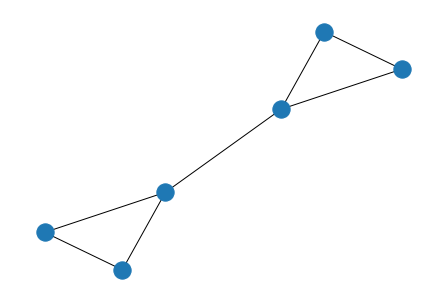

In [29]:
n = 3
k = 2
p = 1
q = 0.2
g = StochasticBlockModel(n, k, p, q, plot=True)

## Laplacian spectral

There is also an implementation for the adjecancy and Laplacian matrices of a graph as well in `networkx`.

In [30]:
g.nodes()

NodeView((0, 1, 2, 3, 4, 5))

In [31]:
# adjecency matrix
A = nx.adjacency_matrix(g).A
print(A)

[[0 1 1 0 0 0]
 [1 0 1 0 0 0]
 [1 1 0 1 0 0]
 [0 0 1 0 1 1]
 [0 0 0 1 0 1]
 [0 0 0 1 1 0]]


In [32]:
# Laplacian matrix
L = nx.laplacian_matrix(g).A
print(L)

[[ 2 -1 -1  0  0  0]
 [-1  2 -1  0  0  0]
 [-1 -1  3 -1  0  0]
 [ 0  0 -1  3 -1 -1]
 [ 0  0  0 -1  2 -1]
 [ 0  0  0 -1 -1  2]]


I used the `scipy` package to calculate the eigenvalues and the corresponding eigenvectors.

In [33]:
w, v = eigh(L)
w, v

(array([-4.21239688e-16,  4.38447187e-01,  3.00000000e+00,  3.00000000e+00,
         3.00000000e+00,  4.56155281e+00]),
 array([[-0.40824829,  0.46470513,  0.        ,  0.76376262,  0.        ,
          0.18452409],
        [-0.40824829,  0.46470513, -0.53452248, -0.54554473,  0.        ,
          0.18452409],
        [-0.40824829,  0.26095647,  0.53452248, -0.21821789,  0.        ,
         -0.6571923 ],
        [-0.40824829, -0.26095647,  0.53452248, -0.21821789,  0.        ,
          0.6571923 ],
        [-0.40824829, -0.46470513, -0.26726124,  0.10910895, -0.70710678,
         -0.18452409],
        [-0.40824829, -0.46470513, -0.26726124,  0.10910895,  0.70710678,
         -0.18452409]]))

In [34]:
np.linalg.eig(L)

(array([4.56155281e+00, 3.00000000e+00, 1.51300012e-16, 4.38447187e-01,
        3.00000000e+00, 3.00000000e+00]),
 array([[ 0.18452409, -0.76376262, -0.40824829, -0.46470513, -0.04778662,
          0.03549245],
        [ 0.18452409,  0.54554473, -0.40824829, -0.46470513,  0.50049386,
         -0.42291195],
        [-0.6571923 ,  0.21821789, -0.40824829, -0.26095647, -0.45270724,
          0.3874195 ],
        [ 0.6571923 ,  0.21821789, -0.40824829,  0.26095647, -0.45270724,
          0.3874195 ],
        [-0.18452409, -0.10910895, -0.40824829,  0.46470513, -0.11632899,
         -0.66522385],
        [-0.18452409, -0.10910895, -0.40824829,  0.46470513,  0.56903622,
          0.27780436]]))

What is really convenient that the eigenvectors are already ordered (ascending order).

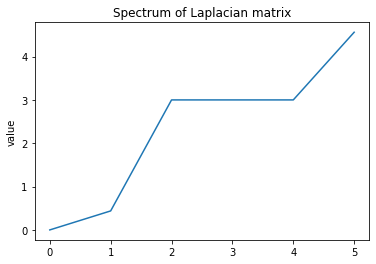

In [35]:
plt.plot(w)
plt.title('Spectrum of Laplacian matrix')
plt.ylabel('value')
plt.show()

## K-means clustering

Then, I use the `sklearn` package to run the KMeans algorithm.

In [36]:
v[:,1:3]

array([[ 0.46470513,  0.        ],
       [ 0.46470513, -0.53452248],
       [ 0.26095647,  0.53452248],
       [-0.26095647,  0.53452248],
       [-0.46470513, -0.26726124],
       [-0.46470513, -0.26726124]])

In [37]:
# the KMeans().fit(X) method expects an array-like X of shape (n_samples, n_features)
# as we project the eigenvectors to R^r we need to transpose w to acquire the projection of the vertices
kmeans = KMeans(n_clusters=k, init='k-means++').fit(v[:,1:1+k])
kmeans

KMeans(n_clusters=2)

I calculate the true labels and extract the predicted labels from the `kmeans` object.

In [38]:
labels_true = np.hstack([np.repeat(i, m) for i, m in enumerate([n]*k)])
labels_pred = kmeans.labels_

Finally, I use adjusted rand score metric from `sklearn` to measure the prediction.

In [39]:
labels_true

array([0, 0, 0, 1, 1, 1])

In [40]:
labels_pred

array([0, 0, 0, 1, 1, 1])

In [43]:
#plt.scatter(v[:,1:1+k][0], v[:,1:1+k][1], color=['green' if i == 1 else 'blue' for i in labels_true])
#plt.title('Ground truth')
#plt.show()

In [44]:
#plt.scatter(v[1:1+k][0], v[1:1+k][1], color=['green' if i == 1 else 'blue' for i in labels_pred])
#plt.title('K-means')
#plt.show()

In [45]:
adjusted_rand_score(labels_true, labels_pred)

1.0

# Measurements

array([[ 0.59701493,  0.        ,  0.05970149,  0.        , -0.11940299],
       [ 0.29411765,  0.        ,  0.03599649,  0.        , -0.11940299],
       [ 0.29411765,  1.        ,  0.        ,  0.        , -0.0119403 ],
       [ 1.        ,  0.59701493,  0.29411765,  0.        ,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  0.29411765,  0.        ]])

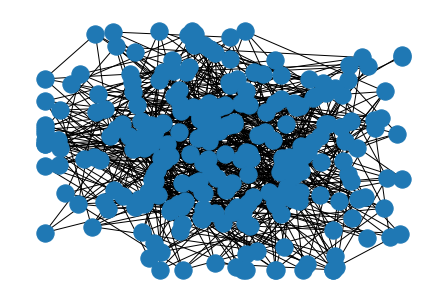

In [23]:
Measurements(5, 2, plot=True)

In [24]:
Measurements(5, 3)

array([[ 0.2359882 ,  0.40117994, -0.00900901,  0.31858407, -0.0161036 ],
       [ 0.31858407,  0.330033  , -0.00900901,  0.04720213, -0.05729167],
       [ 0.79207921,  0.41939184, -0.00900901,  0.10333432,  0.16010081],
       [ 1.        ,  0.53717178, -0.00900901,  0.33333333,  0.17817109],
       [ 1.        ,  1.        ,  1.        ,  0.125     ,  0.51724138]])

In [25]:
Measurements(5, 4)

array([[ 6.20567376e-03,  6.31682143e-02,  2.77379244e-02,
        -2.51683340e-02, -7.89898131e-03],
       [ 1.20370370e-01,  8.28082896e-02,  9.90702620e-02,
        -1.04353002e-02,  3.25019902e-02],
       [ 2.51968504e-01,  3.08040970e-01,  2.30327616e-01,
         9.52380952e-02,  7.43818329e-04],
       [ 5.12820513e-01,  7.09436020e-01,  2.96321435e-01,
         2.24542373e-01,  1.36948677e-01],
       [ 1.00000000e+00,  1.00000000e+00,  2.71087944e-01,
         3.88911484e-01,  2.15301322e-01]])

In [26]:
Measurements(10, 2)

array([[ 1.        , -0.0193133 ,  0.        ,  0.02145923,  0.02145923],
       [ 1.        , -0.0193133 ,  0.        ,  0.02145923, -0.03485839],
       [ 1.        ,  1.        ,  0.62084257,  0.02145923, -0.0193133 ],
       [ 1.        ,  1.        ,  1.        ,  0.7995558 ,  0.32594235],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ]])

In [27]:
Measurements(10, 3)

array([[ 0.33920077,  0.00495479,  0.25231762,  0.00565044, -0.00179787],
       [ 0.89817039,  0.49975818,  0.28870267,  0.00804854,  0.09884773],
       [ 1.        ,  1.        ,  0.51771511,  0.21356072,  0.07301103],
       [ 1.        ,  1.        ,  1.        ,  0.008325  ,  0.36870086],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  0.69819244]])

In [28]:
Measurements(10, 4)

array([[ 0.42023634,  0.09350096,  0.03558162,  0.01181925, -0.00236791],
       [ 0.93152204,  0.28697061,  0.19657654,  0.00147995,  0.00736846],
       [ 1.        ,  0.7215683 ,  0.30923722,  0.073655  ,  0.09568943],
       [ 1.        ,  0.93152204,  0.93152204,  0.4644732 ,  0.46958924],
       [ 1.        ,  1.        ,  1.        ,  0.9931522 ,  0.5942492 ]])